In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import TensorBoard
from keras.models import load_model
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
root = 'ToiletSoundSet'
data_set_folder = root + '/sound_data'
test_data_set_folder = root + '/validate_data'
target_wav_duration = 2.97
wav_data_shape_x = 128
wav_data_shape_y = 128
total_class_label = 7
batch_size = 128
epochs = 12

### Common Functions

In [3]:
def extract_feature(file_path):
    y, sr = librosa.load(file_path, duration=target_wav_duration)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (wav_data_shape_x, wav_data_shape_y):
        return None, None
    return ps, sr

def import_sound_data(folder_path):
    imported_count = 0
    imported_data_set = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_name, file_extension = os.path.splitext(file)
            if file_extension != '.wav': continue
            file_path = os.path.join(root, file)
            ps, sr = extract_feature(file_path)
            if sr == None:
                continue
            class_id = file_name.split('-')[1]
            imported_data_set.append((ps, class_id))
            imported_count += 1
    print('Import finish for folder:{}'.format(folder_path))
    return imported_data_set, imported_count

### Import Train Data Set

In [4]:
train_folder_paths = []
for root, dirnames, _ in os.walk(data_set_folder):
    for dir_name in dirnames:
        wav_folder_path = os.path.join(root, dir_name)
        train_folder_paths.append(wav_folder_path)
print('import_folder_paths:{}'.format(train_folder_paths))

import_folder_paths:['ToiletSoundSet/sound_data/toilet_flush', 'ToiletSoundSet/sound_data/children_playing', 'ToiletSoundSet/sound_data/shower', 'ToiletSoundSet/sound_data/clapping', 'ToiletSoundSet/sound_data/dog_bark', 'ToiletSoundSet/sound_data/broken_glass', 'ToiletSoundSet/sound_data/door']


In [5]:
train_data_set = []
total_import_count = 0
for folder_path in train_folder_paths:
    imported_data_set, imported_count = import_sound_data(folder_path)
    train_data_set.extend(imported_data_set)
    total_import_count += imported_count

Import finish for folder:ToiletSoundSet/sound_data/toilet_flush
Import finish for folder:ToiletSoundSet/sound_data/children_playing
Import finish for folder:ToiletSoundSet/sound_data/shower
Import finish for folder:ToiletSoundSet/sound_data/clapping
Import finish for folder:ToiletSoundSet/sound_data/dog_bark
Import finish for folder:ToiletSoundSet/sound_data/broken_glass
Import finish for folder:ToiletSoundSet/sound_data/door


### Import Validate Data Set

In [7]:
test_folder_paths = []
for root, dirnames, _ in os.walk(test_data_set_folder):
    for dir_name in dirnames:
        wav_folder_path = os.path.join(root, dir_name)
        test_folder_paths.append(wav_folder_path)
print('test_folder_paths:{}'.format(test_folder_paths))

test_folder_paths:['ToiletSoundSet/validate_data/toilet_flush', 'ToiletSoundSet/validate_data/children_playing', 'ToiletSoundSet/validate_data/shower', 'ToiletSoundSet/validate_data/clapping', 'ToiletSoundSet/validate_data/dog_bark', 'ToiletSoundSet/validate_data/broken_glass', 'ToiletSoundSet/validate_data/door']


In [8]:
test_data_set = []
test_import_count = 0
for folder_path in test_folder_paths:
    imported_data_set, imported_count = import_sound_data(folder_path)
    test_data_set.extend(imported_data_set)
    test_import_count += imported_count

Import finish for folder:ToiletSoundSet/validate_data/toilet_flush
Import finish for folder:ToiletSoundSet/validate_data/children_playing
Import finish for folder:ToiletSoundSet/validate_data/shower
Import finish for folder:ToiletSoundSet/validate_data/clapping
Import finish for folder:ToiletSoundSet/validate_data/dog_bark
Import finish for folder:ToiletSoundSet/validate_data/broken_glass
Import finish for folder:ToiletSoundSet/validate_data/door


### Train Model

In [9]:
print('Train data set count:{}'.format(len(train_data_set)))
print('Test data set count:{}'.format(len(test_data_set)))

random.shuffle(train_data_set)
random.shuffle(test_data_set)
X_train, y_train = zip(*train_data_set)
X_test, y_test = zip(*test_data_set)

# Reshape for CNN input
X_train = np.array([x.reshape( (wav_data_shape_x, wav_data_shape_y, 1) ) for x in X_train])
X_test = np.array([x.reshape( (wav_data_shape_x, wav_data_shape_y, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, total_class_label))
y_test = np.array(keras.utils.to_categorical(y_test, total_class_label))

Train data set count:2744
Test data set count:204


In [10]:
model = Sequential()

# Input
input_shape=(wav_data_shape_x, wav_data_shape_y, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))

model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))

model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

# Output
model.add(Dense(total_class_label))
model.add(Activation('softmax'))

In [11]:
model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=['accuracy'])

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data= (X_test, y_test),
    shuffle=False
)

score = model.evaluate(
    x=X_test,
    y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 2744 samples, validate on 204 samples
Epoch 1/12
2744/2744 [==============================] - 28s 10ms/step - loss: 2.2772 - acc: 0.3079 - val_loss: 1.8909 - val_acc: 0.4265
Epoch 2/12
2744/2744 [==============================] - 27s 10ms/step - loss: 1.7022 - acc: 0.4698 - val_loss: 1.8456 - val_acc: 0.4951
Epoch 3/12
2744/2744 [==============================] - 27s 10ms/step - loss: 1.4713 - acc: 0.5532 - val_loss: 2.0430 - val_acc: 0.5637
Epoch 4/12
2744/2744 [==============================] - 27s 10ms/step - loss: 1.3044 - acc: 0.5926 - val_loss: 1.9686 - val_acc: 0.6176
Epoch 5/12
2744/2744 [==============================] - 27s 10ms/step - loss: 1.1455 - acc: 0.6512 - val_loss: 2.1951 - val_acc: 0.6127
Epoch 6/12
2744/2744 [==============================] - 26s 9ms/step - loss: 1.0169 - acc: 0.6855 - val_loss: 2.1453 - val_acc: 0.6422
Epoch 7/12
2744/2744 [==============================] - 26s 10ms/step - loss: 0.9334 - acc: 0.7044 - val_loss: 2.3565 - val_acc: 0.6422
Ep

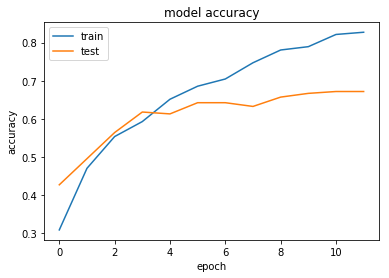

In [12]:
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

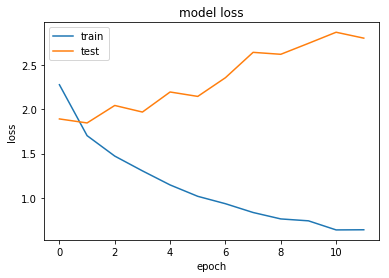

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
model.save('models/toilet_sound_cnn_67.h5')